In [60]:
import re
import glob
import pickle
import random

from tqdm.auto import tqdm

In [61]:
# fns = glob.glob("../../lotsawa/pos_tags/target_token_count/*.pkl")
fns = glob.glob("../../lotsawa/pos_tags/*.pkl")

In [62]:
all_sents = []
for fn in tqdm(fns):
    with open(fn, 'rb') as f:
        all_sents.extend(pickle.load(f))

  0%|          | 0/103 [00:00<?, ?it/s]

In [63]:
len(all_sents)

1038341

In [64]:
by_sent = {
    re.sub("[A-Z\[\]]", "", ''.join(words)).replace('།།', '། །').strip(): (words, tags) for words, tags in tqdm(all_sents)
}
len(by_sent)

  0%|          | 0/1038341 [00:00<?, ?it/s]

910364

# Explore

In [6]:
import pandas as pd

In [7]:
all_tags = sorted(list(set([tag for _, tags in all_sents for tag in tags])))
len(all_tags)

34

In [8]:
by_tag_weighted = {tag: [] for tag in all_tags}
for words, tags in all_sents:
    for word, tag in zip(words, tags):
        by_tag_weighted[tag].append(word)

by_tag = {word: sorted(list(set(tags))) for word, tags in by_tag_weighted.items()}

<AxesSubplot: >

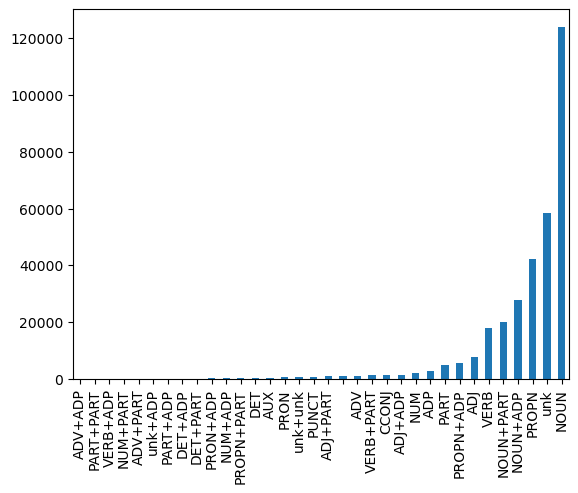

In [9]:
counts = {tag: len(words) for tag, words in by_tag.items()}
pd.Series(counts).sort_values().plot(kind='bar')

In [10]:
by_len = {len_: [] for len_ in set([len(words) for words, _ in all_sents])}
for words, tags in all_sents:
    by_len[len(words)].append((words, tags))

<AxesSubplot: >

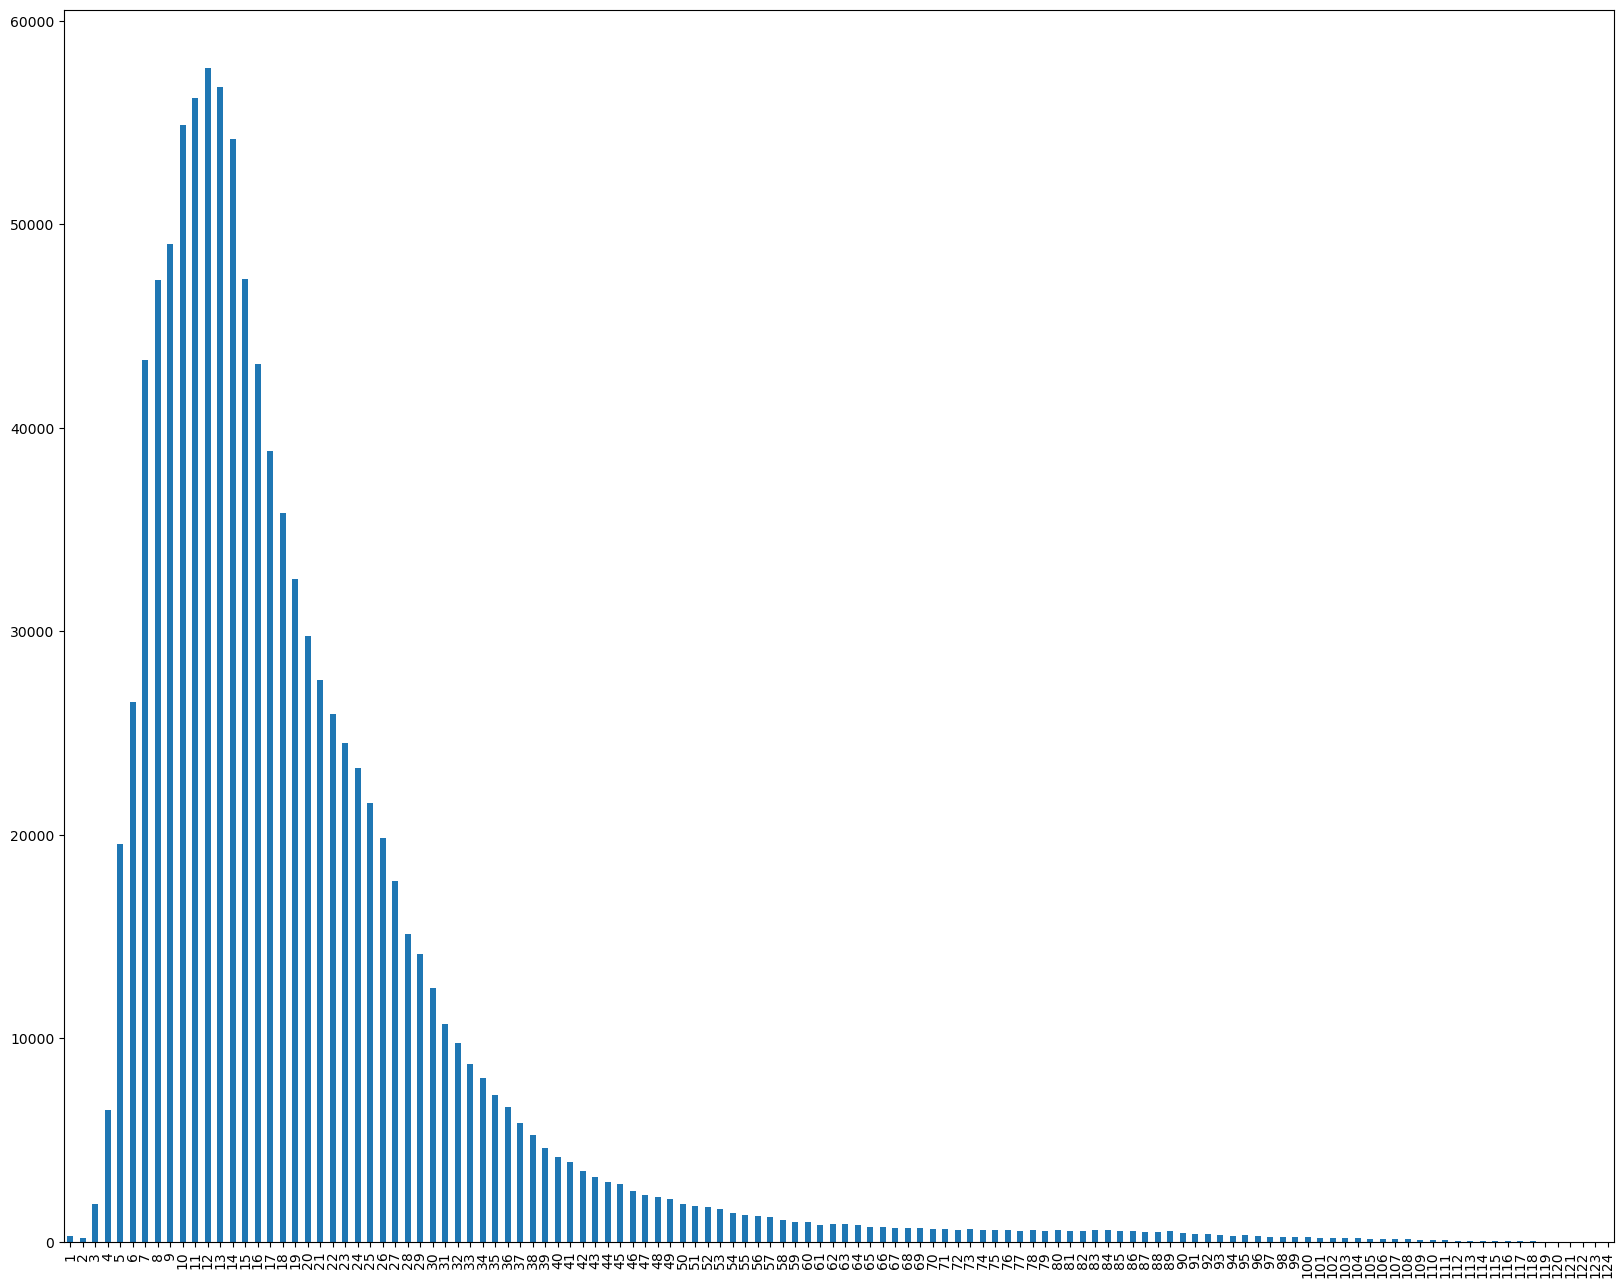

In [11]:
pd.Series({len_: len(examples) for len_, examples in by_len.items()}).plot(kind='bar', figsize=(20,16))

# Explore possible templates

In [12]:
import numpy as np
import pandas as pd

In [13]:
cand_pos = by_len[7]
len(cand_pos)

43329

In [14]:
cand_pos[0]

(['[CLS]', 'དེས་', 'བློན་པོ་', 'རྣམས་', 'ལ་', 'སྨྲས་པ', '།[SEP]'],
 ['', 'DET+ADP', 'NOUN', 'PART', 'ADP', 'NOUN', 'PUNCT'])

In [15]:
templates = {}
for words, tags in cand_pos:
    template = '-'.join(tags)
    templates[template] = templates.get(template, []) + ['-'.join(words)]

for template, words in templates.items():
    templates[template] = [w.split('-') for w in sorted(list(set(words)))]

In [16]:
by_len = pd.Series({template: len(words) for template, words in templates.items()}).sort_values()
by_len

-unk-DET-CCONJ-PART-AUX-PUNCT                  1
-NOUN-PRON-NOUN-PART-VERB-PUNCT                1
-NOUN+PART-NOUN+PART-PART-NOUN-ADP-PUNCT       1
-DET-ADP-NOUN+PART-CCONJ-NOUN+PART-VERB        1
-NOUN+ADP-PRON-ADP-DET-NOUN-PART               1
                                            ... 
-NOUN+ADP-NOUN-VERB-VERB-PART-PUNCT          113
-NOUN-PART-VERB-VERB-PART-PUNCT              220
-unk-unk-unk-unk-unk-PUNCT                   280
-NOUN-ADP-NOUN-VERB-PART-PUNCT               585
-NOUN-CCONJ-PROPN-unk-VERB+PART-PUNCT       1192
Length: 11287, dtype: int64

In [17]:
by_len[by_len > 50].describe(percentiles=np.arange(0.9, 1.001, 0.01))

count      30.000000
mean      138.666667
std       224.354604
min        51.000000
50%        71.000000
90%       226.000000
91%       243.400000
92%       260.800000
93%       278.200000
94%       359.300000
95%       447.750000
96%       536.200000
97%       663.910000
98%       839.940000
99%      1015.970000
100%     1192.000000
max      1192.000000
dtype: float64

In [18]:
to_pick = by_len.index[-4]
to_pick

'-NOUN-PART-VERB-VERB-PART-PUNCT'

# Test out sentence surgery

In [19]:
! rm -rf /tmp/dask-worker-space

In [20]:
import logging
from dask.distributed import Client, LocalCluster

dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

dask_client = Client(LocalCluster(
    n_workers=20,
    threads_per_worker=1
))

# dask_client

In [21]:
from cai_common.dict import TibetanDict

dict_ = TibetanDict(glob_override="processed_datasets/tibetan-english-dictionaries-for-aug/*")

In [22]:
import re
import copy

from cai_garland.utils.translator import Translator

In [23]:
translator = Translator("olive-cormorant-nllb/base-600M")

translator.num_beams = 50
translator.decoding_length = 200

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


In [26]:
# words, tags = random.choice(all_sents)
# words, tags = random.choice(by_len[7])
tags = to_pick.split('-')
words = random.choice(templates[to_pick])
sent = re.sub("[A-Z\[\]]", "", ''.join(words)).replace('།།', '། །').strip()
sent

'།འཁྲུལ་འཁོར་ཐམས་ཅད་འགེམས་པར་བྱེད་དོ།'

In [27]:
translator.translate(sent, generator_kwargs={"repetition_penalty": 2.2, "no_repeat_ngram_size": 3})

'one will burn all the diagrams.'

In [28]:
' '.join([f"{word}-{tag}" for word, tag in zip(words, tags)])

'[CLS] །- འཁྲུལ་འཁོར་-NOUN ཐམས་ཅད་-PART འགེམས་-VERB པར་བྱེད་-VERB དོ-PART །[SEP]-PUNCT'

In [29]:
translator.decoding_length = 10
for to_replace in tqdm(words[1:-1]):
    print(to_replace)
    print(dict_[to_replace])
    print(translator.translate(
        to_replace,
        generator_kwargs={"repetition_penalty": 2.2, "no_repeat_ngram_size": 3}
    ))
    print()
translator.decoding_length = 200

  0%|          | 0/5 [00:00<?, ?it/s]

འཁྲུལ་འཁོར་
['(lit. machine) yogic exercises', "1) [adhisara] [yogic] exercise, [hatha yoga]. 2) [yantra] magical wheel. 3) vicious cycle, wheel, cycle of confusion, samsaric confusion, deceptive round, vicious circle, deceptive round, 4) gadgetry, mechanism, machinery, 5) black magic. Syn {mig 'khrul} Syn {'phrul 'khor} 6) craft, artifice", 'esoteric yogic practice', 'magical wheel', 'mechanism', 'Yogic practices. Exercises utilized in the Six Doctrines of Naropa', 'yantra', 'yantra', 'yantra', 'yantra']
an illusion,

ཐམས་ཅད་
['everyone', 'the entire', 'whole, all, everything, everybody', 'everyone']
all of them,

འགེམས་
["Syn {'joms}"]
one will be arrested

པར་བྱེད་
None
promote it,

དོ
["1) sentence ending particle [used after the final 'd']. 2) match, counterpart, equal, island two, a pair, a couple"]
tha.



In [57]:
to_replace = "ནད་"
to_replace, tags[words.index(to_replace)]

('ནད་', 'NOUN')

In [59]:
random_word = random.choice(by_tag_weighted[tags[words.index(to_replace)]])
print(random_word)
dict_[random_word]

ཆུ་རྒྱུན་


['1) river, stream. 2) the flow of rivers, current', 'rivulets']

In [60]:
changed_words = copy.deepcopy(words)
changed_words[changed_words.index(to_replace)] = random_word
changed_sent = re.sub("[A-Z\[\]]", "", ''.join(changed_words)).replace('།།', '། །').strip()
changed_sent

'ཆུ་རྒྱུན་ཐམས་ཅད་སོས་པར་གྱུར་ཏེ།'

In [61]:
translator.translate(
    changed_sent,
    generator_kwargs={
        "repetition_penalty": 2.2,
        "no_repeat_ngram_size": 3,
        # "force_words_ids": [meaning_tokens]
    }
)

'and all the streams of water were healed.'

In [35]:
# meaning = "play"
# with translator.tokenizer.as_target_tokenizer():
#     meaning_tokens = translator.tokenizer.encode(meaning, add_special_tokens=False)
#     print(meaning_tokens, translator.tokenizer.decode(meaning_tokens), meaning)

# Lexer experiments

In [64]:
# import spacy

# nlp = spacy.load("en_core_web_sm")

In [ ]:
# doc = nlp('he will cure all illnesses.')

# for token in doc:
#     print(token)
#     print(token.morph)
#     print(token.morph.get("PronType"))
#     print(token.lemma_)
#     print()

In [72]:
# import nltk
# nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/eeisenst/nltk_data...


True

In [18]:
from pattern.en import conjugate, lemma, lexeme, PRESENT, SG

In [20]:
from transformers import RobertaTokenizer, RobertaForMaskedLM
import torch

tokenizer = RobertaTokenizer.from_pretrained("roberta-large")
model = RobertaForMaskedLM.from_pretrained("roberta-large")

In [21]:
sent = "he will cure all <mask><mask>"

In [22]:
input_ = tokenizer(sent, return_tensors="pt")

In [23]:
with torch.no_grad():
    logits = model(**input_).logits

In [24]:
mask_token_index = (input_.input_ids == tokenizer.mask_token_id)[0].nonzero(as_tuple=True)[0]
predicted_token_id = logits[0, mask_token_index].argmax(axis=-1)
tokenizer.decode(predicted_token_id)

' diseases.'

In [71]:
word = " fraction"
lexemes = lexeme(word)
lexemes

[' fraction', ' fractions', ' fractioning', ' fractioned']

In [72]:
candidates = tokenizer.batch_encode_plus(lexeme(word), add_special_tokens=False)['input_ids']
candidates, max(map(len, candidates))

([[13484], [44807], [13484, 154], [13484, 196]], 2)

In [73]:
from scipy.special import log_softmax, softmax

scores = []

mask_idxs = (input_['input_ids'][0] == tokenizer.mask_token_id).nonzero().squeeze().tolist()
for idx, cand_ts in enumerate(candidates):
    cur_scores = []
    for cand_t, mask_i in zip(cand_ts, mask_idxs):
        cur_scores.append(float(logits[0][mask_i][cand_t]))
    print(cur_scores)
    scores.append(sum(cur_scores) / len(cur_scores))
    print()
scores = np.array(scores)
# scores = log_softmax(scores)

scores, lexemes[scores.argmax()]

[42.83558654785156]

[47.377281188964844]

[42.83558654785156, 53.404937744140625]

[42.83558654785156, 52.885501861572266]



(array([42.83558655, 47.37728119, 48.12026215, 47.8605442 ]), ' fractioning')

<AxesSubplot: >

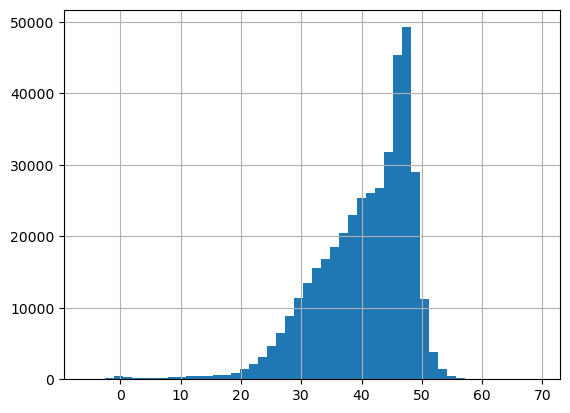

In [48]:
pd.Series(logits.flatten()).hist(bins=50)

# Captum experiments

In [1]:
! rm -rf /tmp/dask-worker-space

In [2]:
import torch

import pandas as pd

from tqdm.auto import tqdm
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
from cai_garland.utils.translator import Translator

In [3]:
import logging
from dask.distributed import Client, LocalCluster

dask_logger = logging.getLogger("distributed.utils_perf")
dask_logger.setLevel(logging.ERROR)

dask_client = Client(LocalCluster(
    n_workers=20,
    threads_per_worker=1
))

# dask_client

In [4]:
from cai_common.dict import TibetanDict

dict_ = TibetanDict(glob_override="processed_datasets/tibetan-english-dictionaries-for-aug/*")

In [5]:
translator = Translator("olive-cormorant-nllb/base-600M")

translator.num_beams = 50
translator.decoding_length = 200

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'NllbTokenizer'. 
The class this function is called from is 'CAINllbTokenizerFast'.


In [66]:
def make_viz_record(attributions, inputs, pred, pred_ind, label, delta, tokenizer):
    attributions = attributions.sum(dim=2).squeeze(0)
    print(' '.join([f"{att:>8.3f}" for att in attributions.tolist()]))
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    
    with tokenizer.as_target_tokenizer():
        label = tokenizer.decode(label)
    
    return visualization.VisualizationDataRecord(
        attributions,
        0.5,
        pred_ind,
        label,
        label,
        attributions.sum(),
        tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].tolist()),
        delta
    )

def lig_attribs(source, target, next_target, translator):
    translator.model.zero_grad()

    inputs = translator.tokenizer(source, return_tensors="pt")
    with translator.tokenizer.as_target_tokenizer():
        _ = translator.tokenizer(target, return_tensors="pt")
        inputs['decoder_input_ids'] = _['input_ids']
        inputs['decoder_attention_mask'] = _['attention_mask']
        del _
    with translator.tokenizer.as_target_tokenizer():
        label = translator.tokenizer(next_target, return_tensors="pt")['input_ids']
    label = label[0, 2:-1]

    pad_index = translator.tokenizer.pad_token_id
    token_reference = TokenReferenceBase(reference_token_idx=pad_index)
    seq_length = inputs['input_ids'].shape[1]
    input_indices = inputs['input_ids']
    device = translator.model.device
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)
    reference_indices[0][0], reference_indices[0][-1] = translator.tokenizer.bos_token_id, translator.tokenizer.eos_token_id

    def forward_func(input_ids):
        new_inputs = {}
        new_inputs['input_ids'] = input_ids
        new_inputs['attention_mask'] = torch.ones_like(input_ids)
        new_inputs['decoder_input_ids'] = inputs['decoder_input_ids'].repeat(input_ids.shape[0], 1)
        new_inputs['decoder_attention_mask'] = inputs['decoder_attention_mask'].repeat(input_ids.shape[0], 1)
        logits = translator.model(**new_inputs).logits[0][-2]
        return logits

    lig = LayerIntegratedGradients(forward_func, translator.model.encoder.embeddings.word_embeddings)

    attributions_ig, delta = lig.attribute(input_indices, reference_indices, n_steps=500, return_convergence_delta=True)

    return inputs, label, attributions_ig, sum([abs(delta[l]) for l in label]) / len(label)

def attrib_all_words(source, target, translator):
    target_words = target.split(' ')
    viz_records = []
    for w_idx, word in tqdm(enumerate(target_words), total=len(target_words)):
        cur_target = ' '.join(target_words[:w_idx + 1])
        inputs, label, attribs, delta = lig_attribs(source, cur_target, word, translator)
        if inputs is None:
            continue
        viz_records.append(make_viz_record(attribs, inputs, cur_target, -1, label, delta, translator.tokenizer))
    _ = visualization.visualize_text(viz_records)

In [72]:
# source, target = "ནད་ཐམས་ཅད་སོས་པར་གྱུར་ཏེ།", "he will cure all diseases"
# source, target = '།སྐྱེ་བོ་ཐམས་ཅད་དགའ་བར་འགྱུར་རོ།', 'one will be loved by everyone.'
source, target = '།འཁྲུལ་འཁོར་ཐམས་ཅད་འགེམས་པར་བྱེད་དོ།', 'one will burn all the diagrams.'

print(
    ' '.join([
        f"{i}-{t}" for i, t in enumerate(translator.tokenizer.convert_ids_to_tokens(translator.tokenizer.encode(source)))
    ])
)
print(target)

0-[CLS] 1-▁ 2-། 3-འཁྲུལ་འཁོར་ 4-ཐམས་ཅད་ 5-འགེམས་ 6-པར་བྱེད་ 7-ད 8-ོ 9-། 10-[SEP]
one will burn all the diagrams.


In [ ]:
attrib_all_words(source, target, translator)

  0%|          | 0/6 [00:00<?, ?it/s]

   0.000   -0.215   -0.123    0.379    0.090   -0.378   -0.049   -0.303   -0.189   -0.081    0.000
   0.000   -0.311   -0.069    0.149    0.083   -0.245   -0.071   -0.248   -0.181   -0.041    0.000
   0.000   -0.356   -0.098    0.211    0.064   -0.160   -0.091   -0.186   -0.177    0.102    0.000
   0.000   -0.309   -0.106    0.181    0.124   -0.196   -0.071   -0.200   -0.164    0.085    0.000


In [ ]:
words, tags = by_sent[source]

translator.decoding_length = 10
for to_replace in tqdm(words[1:-1]):
    print(to_replace)
    print(dict_[to_replace])
    print(translator.translate(
        to_replace,
        generator_kwargs={"repetition_penalty": 2.2, "no_repeat_ngram_size": 3}
    ))
    print()
translator.decoding_length = 200

In [119]:
source, target, next_target = '།སྐྱེ་བོ་ཐམས་ཅད་དགའ་བར་འགྱུར་རོ།', 'one will be loved by ', 'everyone'

In [120]:
inputs = translator.tokenizer(source, return_tensors="pt")
with translator.tokenizer.as_target_tokenizer():
    _ = translator.tokenizer(target, return_tensors="pt")
    inputs['decoder_input_ids'] = _['input_ids']#[:,:-1]
    inputs['decoder_attention_mask'] = _['attention_mask']#[:,:-1]
    del _
# with translator.tokenizer.as_target_tokenizer():
#     label = translator.tokenizer(next_target, return_tensors="pt")['input_ids']
# label = label[0, 2:-1]

new_inputs = {}
new_inputs['input_ids'] = inputs['input_ids']
new_inputs['attention_mask'] = torch.ones_like(inputs['input_ids'])
new_inputs['decoder_input_ids'] = inputs['decoder_input_ids'].repeat(inputs['input_ids'].shape[0], 1)[:,:-1]
new_inputs['decoder_attention_mask'] = inputs['decoder_attention_mask'].repeat(inputs['input_ids'].shape[0], 1)[:,:-1]
logits = translator.model(**new_inputs).logits#[0][-1]

In [122]:
new_inputs['decoder_input_ids']

tensor([[90590, 90590,  2162,  1808,   195, 40536,   499, 90555]])

In [130]:
with translator.tokenizer.as_target_tokenizer():
    i = -3
    print(translator.tokenizer.decode([inputs['decoder_input_ids'][0][i]]))
    print(translator.tokenizer.batch_decode(logits[0][i].topk(50).indices.unsqueeze(-1)))

by
['by', '.', '</s>', 'and', ',', 'to', 'as', 'all', 'ones', 'each', 'in', 'throughout', 'with', 'both', 'among', '.', 'at', 'also', 'only', 'the', 'even', 'not', 'for', 'again', 'or', 'along', 'without', 'too', 'one', 'right', 'be', 'great', 'very', ':', 'whole', 'well', '-', 'ever', 'many', 'loved', 'around', 'will', 'like', 'on', 'dear', 'ly', 'today', 'wh', 'but', 'especially']
